<a href="https://colab.research.google.com/github/yabsera-e/Crop-Segmentation-Yield-Estimation/blob/main/Crop_Segmentation_%2B_Yield_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install patchify

In [ ]:
pip install segmentation_models

     |████████████████████████████████| 50 kB 5.6 MB/s 


In [ ]:
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
from PIL import Image
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [ ]:
import numpy as np
import scipy.signal
from tqdm import tqdm

import gc


if __name__ == '__main__':
    import matplotlib.pyplot as plt
    PLOT_PROGRESS = True
else:
    PLOT_PROGRESS = False
def _spline_window(window_size, power=2):
    intersection = int(window_size/4)
    wind_outer = (abs(2*(scipy.signal.triang(window_size))) ** power)/2
    wind_outer[intersection:-intersection] = 0

    wind_inner = 1 - (abs(2*(scipy.signal.triang(window_size) - 1)) ** power)/2
    wind_inner[:intersection] = 0
    wind_inner[-intersection:] = 0

    wind = wind_inner + wind_outer
    wind = wind / np.average(wind)
    return wind


cached_2d_windows = dict()
def _window_2D(window_size, power=2):
    """
    Make a 1D window function, then infer and return a 2D window function.
    Done with an augmentation, and self multiplication with its transpose.
    Could be generalized to more dimensions.
    """
    # Memoization
    global cached_2d_windows
    key = "{}_{}".format(window_size, power)
    if key in cached_2d_windows:
        wind = cached_2d_windows[key]
    else:
        wind = _spline_window(window_size, power)
        wind = np.expand_dims(np.expand_dims(wind, 1), 1)      #SREENI: Changed from 3, 3, to 1, 1 
        wind = wind * wind.transpose(1, 0, 2)
        if PLOT_PROGRESS:
            # For demo purpose, let's look once at the window:
            plt.imshow(wind[:, :, 0], cmap="viridis")
            plt.title("2D Windowing Function for a Smooth Blending of "
                      "Overlapping Patches")
            plt.show()
        cached_2d_windows[key] = wind
    return wind


def _pad_img(img, window_size, subdivisions):
    """
    Add borders to img for a "valid" border pattern according to "window_size" and
    "subdivisions".
    Image is an np array of shape (x, y, nb_channels).
    """
    aug = int(round(window_size * (1 - 1.0/subdivisions)))
    more_borders = ((aug, aug), (aug, aug), (0, 0))
    ret = np.pad(img, pad_width=more_borders, mode='reflect')
    # gc.collect()

    if PLOT_PROGRESS:
        # For demo purpose, let's look once at the window:
        plt.imshow(ret)
        plt.title("Padded Image for Using Tiled Prediction Patches\n"
                  "(notice the reflection effect on the padded borders)")
        plt.show()
    return ret


def _unpad_img(padded_img, window_size, subdivisions):
    aug = int(round(window_size * (1 - 1.0/subdivisions)))
    ret = padded_img[
        aug:-aug,
        aug:-aug,
        :
    ]
    # gc.collect()
    return ret


def _rotate_mirror_do(im):
    mirrs = []
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    im = np.array(im)[:, ::-1]
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    return mirrs


def _rotate_mirror_undo(im_mirrs):
    origs = []
    origs.append(np.array(im_mirrs[0]))
    origs.append(np.rot90(np.array(im_mirrs[1]), axes=(0, 1), k=3))
    origs.append(np.rot90(np.array(im_mirrs[2]), axes=(0, 1), k=2))
    origs.append(np.rot90(np.array(im_mirrs[3]), axes=(0, 1), k=1))
    origs.append(np.array(im_mirrs[4])[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[5]), axes=(0, 1), k=3)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[6]), axes=(0, 1), k=2)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[7]), axes=(0, 1), k=1)[:, ::-1])
    return np.mean(origs, axis=0)


def _windowed_subdivs(padded_img, window_size, subdivisions, nb_classes, pred_func):

    WINDOW_SPLINE_2D = _window_2D(window_size=window_size, power=2)

    step = int(window_size/subdivisions)
    padx_len = padded_img.shape[0]
    pady_len = padded_img.shape[1]
    subdivs = []

    for i in range(0, padx_len-window_size+1, step):
        subdivs.append([])
        for j in range(0, pady_len-window_size+1, step):            
            patch = padded_img[i:i+window_size, j:j+window_size, :]
            subdivs[-1].append(patch)

    # Here, `gc.collect()` clears RAM between operations.
    # It should run faster if they are removed, if enough memory is available.
    gc.collect()
    subdivs = np.array(subdivs)
    gc.collect()
    a, b, c, d, e = subdivs.shape
    subdivs = subdivs.reshape(a * b, c, d, e)
    gc.collect()

    subdivs = pred_func(subdivs)
    gc.collect()
    subdivs = np.array([patch * WINDOW_SPLINE_2D for patch in subdivs])
    gc.collect()

    # Such 5D array:
    subdivs = subdivs.reshape(a, b, c, d, nb_classes)
    gc.collect()

    return subdivs


def _recreate_from_subdivs(subdivs, window_size, subdivisions, padded_out_shape):
    """
    Merge tiled overlapping patches smoothly.
    """
    step = int(window_size/subdivisions)
    padx_len = padded_out_shape[0]
    pady_len = padded_out_shape[1]

    y = np.zeros(padded_out_shape)

    a = 0
    for i in range(0, padx_len-window_size+1, step):
        b = 0
        for j in range(0, pady_len-window_size+1, step):                #SREENI: Changed padx to pady (Bug in original code)
            windowed_patch = subdivs[a, b]
            y[i:i+window_size, j:j+window_size] = y[i:i+window_size, j:j+window_size] + windowed_patch
            b += 1
        a += 1
    return y / (subdivisions ** 2)


def predict_img_with_smooth_windowing(input_img, window_size, subdivisions, nb_classes, pred_func):
 
    pad = _pad_img(input_img, window_size, subdivisions)
    pads = _rotate_mirror_do(pad)

    res = []
    for pad in tqdm(pads):
        # For every rotation:
        sd = _windowed_subdivs(pad, window_size, subdivisions, nb_classes, pred_func)
        one_padded_result = _recreate_from_subdivs(
            sd, window_size, subdivisions,
            padded_out_shape=list(pad.shape[:-1])+[nb_classes])

        res.append(one_padded_result)

    # Merge after rotations:
    padded_results = _rotate_mirror_undo(res)

    prd = _unpad_img(padded_results, window_size, subdivisions)

    prd = prd[:input_img.shape[0], :input_img.shape[1], :]

    if PLOT_PROGRESS:
        #plt.imshow(prd)
        plt.title("Smoothly Merged Patches that were Tiled Tighter")
        plt.show()
    return prd

In [ ]:
!pip install anvil-uplink
import anvil.server
anvil.server.connect("546KKBRHUSGJR43CJ6QC3U4V-UNCR4I4B36R6HUJK")

     |████████████████████████████████| 64 kB 2.1 MB/s 
     |████████████████████████████████| 51 kB 172 kB/s 
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45229 sha256=d4be0f5f79b828ce72704cc28f369a7c82e85efc1477fa6bbd14950d6cc881ae
  Stored in directory: /root/.cache/pip/wheels/29/ea/7d/3410aa0aa0e4402ead9a7a97ab2214804887e0f5c2b76f0c96
Successfully built ws4py


Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment" as SERVER


In [ ]:
@anvil.server.callable
def predictor():
  from sklearn.preprocessing import MinMaxScaler
  scaler = MinMaxScaler()
  
  #from smooth_tiled_predictions import predict_img_with_smooth_windowing
  
  BACKBONE = 'resnet34'
  preprocess_input = sm.get_preprocessing(BACKBONE)
  img = cv2.imread("/content/drive/MyDrive/ESSTI Project | Crop Yield Estimation/GUI/Uploaded Images/newTempImg.png") 
  #img = cv2.imread("/content/drive/MyDrive/ESSTI Project | Crop Yield Estimation/GUI/Uploaded Images/newTempImg.png")  #N-34-66-C-c-4-3.tif, N-34-97-D-c-2-4.tif
  input_img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
  input_img = preprocess_input(input_img)
  from keras.models import load_model
  model = load_model("/content/drive/MyDrive/ESSTI Project | Crop Yield Estimation/Models/SebilView.hdf5", compile=False)                
  # size of patches
  patch_size = 256
  # Number of classes 
  n_classes = 10
 # img = cv2.imread("/content/drive/MyDrive/ESSTI Project | Crop Yield Estimation/GUI/Uploaded Images/temp_img.png")
 # img = cv2.imread("/content/drive/MyDrive/ESSTI Project | Crop Yield Estimation/GUI/Uploaded Images/newTempImg.png") 
  plt.imshow(img)
  predictions_smooth = predict_img_with_smooth_windowing(
      input_img,
      window_size=patch_size,
      subdivisions=2,  # Minimal amount of overlap for windowing. Must be an even number.
      nb_classes=n_classes,
      pred_func=(
          lambda img_batch_subdiv: model.predict((img_batch_subdiv))
      
      )
  )

  final_prediction = np.argmax(predictions_smooth, axis=2)

#Save prediction and original mask for comparison
  plt.imsave('/content/drive/MyDrive/ESSTI Project | Crop Yield Estimation/GUI/Predictions/Pred.jpg', final_prediction)
  #plt.imshow('/content/drive/MyDrive/ESSTI Project | Crop Yield Estimation/GUI/Uploaded Images/segmented_image.jpg')
#plt.imsave('/content/drive/MyDrive/Crop Identification | Satellite_Imagery /Datasets/otiginal.tif_mask.jpg', original_mask)
###################
"""
plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.title('Testing Image')
plt.imshow(img)
plt.subplot(222)
plt.title('Testing Label')
#plt.imshow(original_mask)
plt.subplot(223)
plt.title('Prediction with smooth blending')
plt.imshow(final_prediction)
plt.show()
"""


"\nplt.figure(figsize=(12, 12))\nplt.subplot(221)\nplt.title('Testing Image')\nplt.imshow(img)\nplt.subplot(222)\nplt.title('Testing Label')\n#plt.imshow(original_mask)\nplt.subplot(223)\nplt.title('Prediction with smooth blending')\nplt.imshow(final_prediction)\nplt.show()\n"

In [ ]:
@anvil.server.callable
def estimate():
  from PIL import Image
  im = Image.open('/content/drive/MyDrive/ESSTI Project | Crop Yield Estimation/GUI/Predictions/Pred.jpg')
  violet = 0
  blue = 0
  lightblue = 0
  yellow = 0
  green = 0
  
  for pixel in im.getdata():
      if pixel == (68, 0, 83): 
          violet += 1
      elif pixel == (71, 44, 123): 
          blue += 1
      elif pixel == (253, 230, 36): 
          yellow += 1
      elif pixel == (172, 220, 48): 
          green += 1
      elif pixel == (41,174,127):
          lightblue += 1
 
  print('violet=' + str(violet)+', blue='+str(blue)+', yellow'+str(yellow)+', green'+str(green))
  total_landcover = 1048576
  violet_yield = 14.20 #barley
  blue_yield = 0        #bare land
  green_yield = 17.1     #wheat
  yellow_yield = 13      #teff
  lightblue_yield = 30.20 #maize

  
  violet_portion=round((violet/total_landcover)*100,2)
  violet_cov = round(violet_portion/100*25,2)
  violet_est = round(violet_cov*violet_yield,2)
  violet_str = 'Barley'
  blue_str = 'Bare Land'
  green_str = 'Wheat'
  yellow_str = 'Teff'
  lightblue_str = 'maize'

  blue_portion=round((blue/total_landcover)*100,2)
  blue_cov = round(blue_portion/100*25,2)
  blue_est = round(blue_cov*blue_yield,2)
  blue_str = 'Bare Land'
  
  yellow_portion=round((yellow/total_landcover)*100,2)
  yellow_cov = round(yellow_portion/100*25,2)
  yellow_est = round(yellow_cov*yellow_yield,2)
  yellow_str = 'Teff'
  
  green_portion=round((green/total_landcover)*100,2)
  green_cov = round(green_portion/100*25,2)
  green_est = round(green_cov*green_yield,2)
  green_str = 'Wheat'

  lightblue_portion=round((lightblue/total_landcover)*100,2)
  lightblue_cov = round(lightblue_portion/100*25,2)
  lightblue_est = round(lightblue_cov*lightblue_yield,2)
  lightblue_str = 'maize'
  
  total_portion = violet_portion + blue_portion + yellow_portion + green_portion
  unidentified = round((100 - total_portion),2)
  
  print('viloet_portion= '+str(violet_portion)+'\n'+'blue_portion= '+str(blue_portion)+'\n'+ 'yellow_portion= '+str(yellow_portion)+'\n'+'green_portion= '+str(green_portion)+'\n'+'unidentified_portion= '+str(unidentified))
  
  return (lightblue_str,lightblue_cov,lightblue_portion,lightblue_est,yellow_str,yellow_cov,yellow_portion,yellow_est,green_str,green_cov,green_portion,green_est,blue_str,blue_cov,blue_portion,blue_est,violet_str,violet_cov,violet_portion,violet_est)


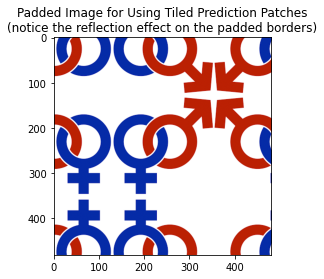

100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


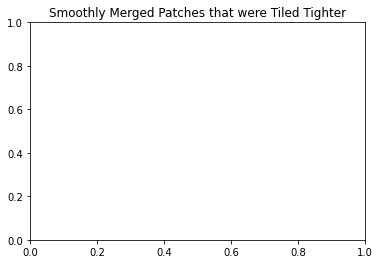

violet=0, blue=0, yellow0, green24379
viloet_portion= 0.0
blue_portion= 0.0
yellow_portion= 0.0
green_portion= 2.32
unidentified_portion= 97.68


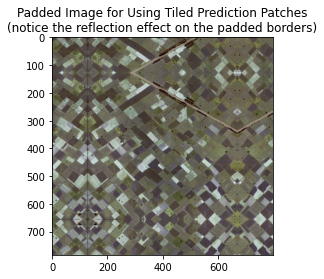

100%|██████████| 8/8 [00:13<00:00,  1.63s/it]


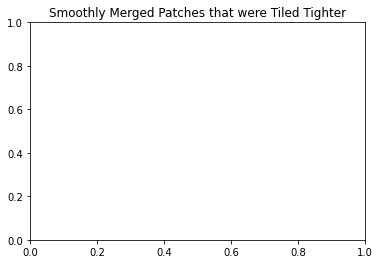

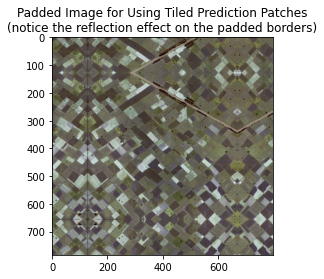

100%|██████████| 8/8 [00:13<00:00,  1.63s/it]


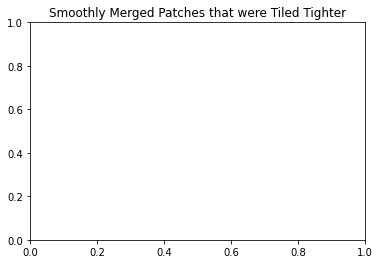

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


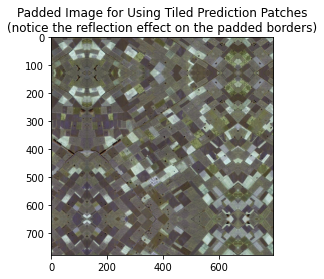

100%|██████████| 8/8 [00:12<00:00,  1.56s/it]


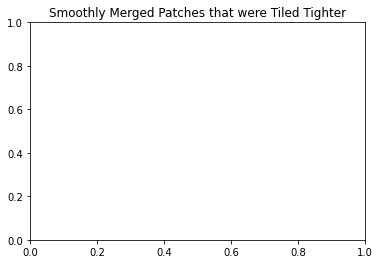

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


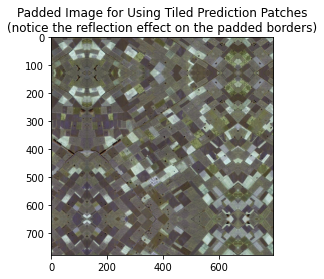

100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


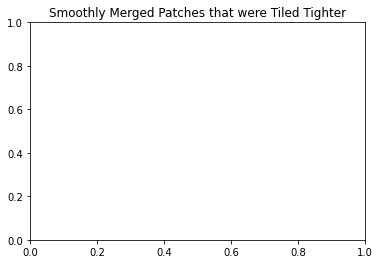

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


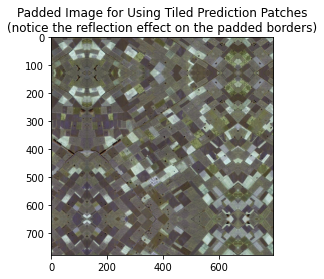

100%|██████████| 8/8 [00:12<00:00,  1.53s/it]


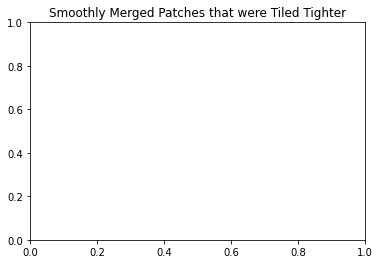

violet=111409, blue=11776, yellow70, green537
viloet_portion= 10.62
blue_portion= 1.12
yellow_portion= 0.01
green_portion= 0.05
unidentified_portion= 88.2


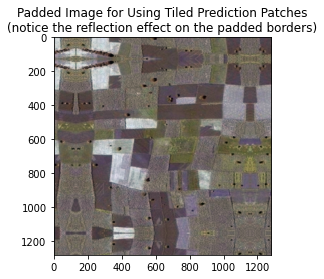

100%|██████████| 8/8 [00:27<00:00,  3.50s/it]


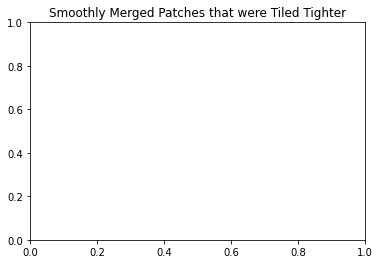

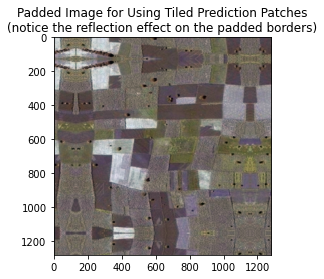

100%|██████████| 8/8 [00:23<00:00,  2.89s/it]


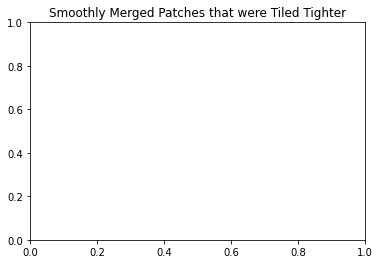

violet=422932, blue=197164, yellow50041, green24681
viloet_portion= 40.33
blue_portion= 18.8
yellow_portion= 4.77
green_portion= 2.35
unidentified_portion= 33.75
violet=422932, blue=197164, yellow50041, green24681
viloet_portion= 40.33
blue_portion= 18.8
yellow_portion= 4.77
green_portion= 2.35
unidentified_portion= 33.75


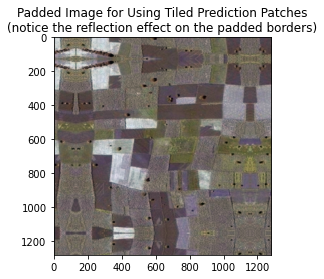

100%|██████████| 8/8 [00:22<00:00,  2.80s/it]


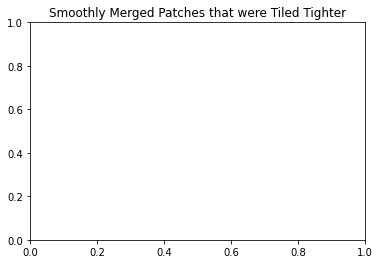

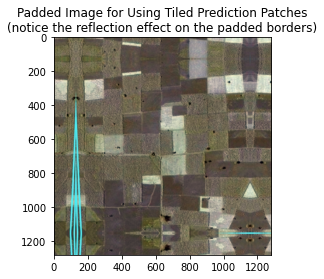

100%|██████████| 8/8 [00:22<00:00,  2.85s/it]


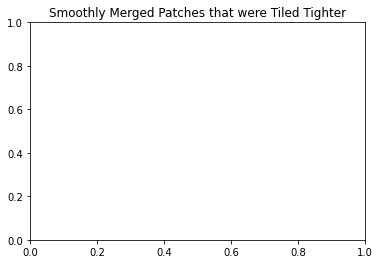

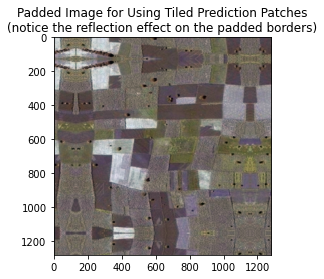

100%|██████████| 8/8 [00:23<00:00,  2.97s/it]


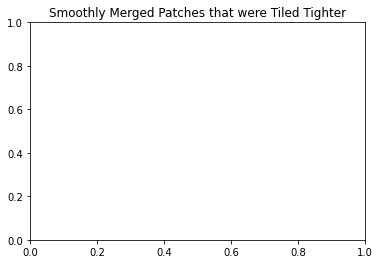

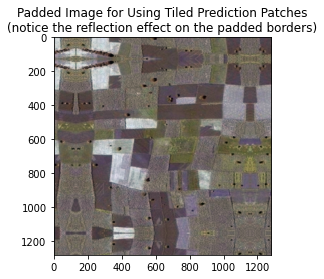

100%|██████████| 8/8 [00:23<00:00,  2.92s/it]


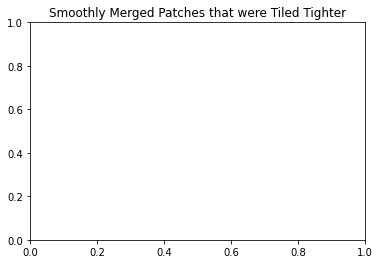

violet=422932, blue=197164, yellow50041, green24681
viloet_portion= 40.33
blue_portion= 18.8
yellow_portion= 4.77
green_portion= 2.35
unidentified_portion= 33.75


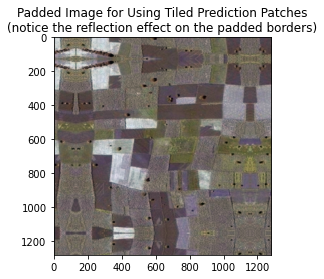

100%|██████████| 8/8 [00:22<00:00,  2.84s/it]


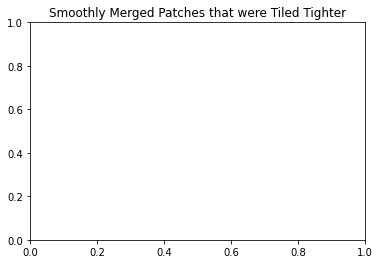

violet=422932, blue=197164, yellow50041, green24681
viloet_portion= 40.33
blue_portion= 18.8
yellow_portion= 4.77
green_portion= 2.35
unidentified_portion= 33.75


In [ ]:
anvil.server.wait_forever()